<a href="https://colab.research.google.com/github/SIDHARTH06/AI_CLUB_LOGO_GEN_GAN/blob/main/AIproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [175]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
from google.colab import drive
import h5py
drive.mount('/content/gdrive')
import keras
from keras.layers import Input,Dense,Reshape,Flatten
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential,Model
from keras.optimizers import Adam

img_rows=32
img_cols=32
channels=3
img_shape=(img_rows,img_cols,channels)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [176]:
hdf5_path="/content/gdrive/My Drive/LLD-icon.hdf5"
dataset=h5py.File(hdf5_path,"r")

In [177]:
def build_generator():  #generator model 3 layers and one final layer
  noise_shape=(100,)
  model=Sequential()
  model.add(Dense(256,input_shape=noise_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(1024))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(np.prod(img_shape),activation='tanh'))
  model.add(Reshape(img_shape))

  model.summary()
  noise=Input(shape=noise_shape)
  img=model(noise)
  
  return Model(noise,img)

In [178]:
def build_discriminator(): #discriminator model 2 layers and one final layer
  
  model=Sequential()
  model.add(Flatten(input_shape=img_shape))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(256))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(1,activation='sigmoid'))
  model.summary()
  
  img=Input(shape=img_shape)
  validity=model(img)
  return Model(img,validity)
  

In [179]:
def train(epochs,batch_size,save_interval): #train function
  images, labels = (dataset['data'], dataset['labels/resnet/rc_64'])
  half_batch=int(batch_size/2)
  for epoch in range(epochs):
    idx=np.random.randint(0,images.shape[0],half_batch)
    imgs=np.zeros((10,32,32,3),dtype=float)
    j=0;
    for i in idx:
       imgs[j]=np.transpose((images[i]-127.5)/127.5)
       j=j+1
    noise=np.random.normal(0,1,(half_batch,100))

    gen_imgs=generator.predict(noise)
    d_loss_real=discriminator.train_on_batch(imgs,np.ones((half_batch,1)))
    d_loss_fake=discriminator.train_on_batch(gen_imgs,np.zeros((half_batch,1))) 
    d_loss=0.5*(np.add(d_loss_real,d_loss_fake)) 
    noise=np.random.normal(0,1,(batch_size,100))
    valid_y=np.array([1]*batch_size)
    g_loss=combined.train_on_batch(noise,valid_y)
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    if epoch%save_interval==0:
      save_imgs(epoch)
    


In [180]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/gan_%d.png" % epoch)
    plt.close()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_22 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_154 (Dense)            (None, 512)               1573376   
_________________________________________________________________
leaky_re_lu_110 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_155 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_111 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_156 (Dense)            (None, 1)                 257       
Total params: 1,704,961
Trainable params: 1,704,961
Non-trainable params: 0
___________________________________________

FileNotFoundError: ignored

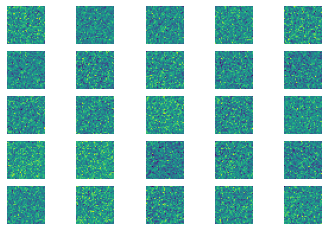

In [181]:
optimizer = Adam(0.0002, 0.5)  #Learning rate and momentum.
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

z = Input(shape=(100,))   #Our random input to the generator
img = generator(z)

discriminator.trainable = False  

valid = discriminator(img)
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
train(epochs=100,batch_size=20,save_interval=50)
generator.save('generator_model.h5')
